# ArXiv Pipeline - Qdrant Semantic Search Analysis

This notebook explores the semantic search capabilities of the ArXiv Pipeline using the Qdrant vector database.

Key analyses include:
- Vector embedding visualization
- Semantic search queries
- Related papers exploration
- Topic clustering analysis
- Research recommendation system

The notebook demonstrates how to use vector embeddings for advanced semantic search and analysis of research papers.

In [24]:
# Import required libraries
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qdrant_client import QdrantClient
from qdrant_client.http import models
from pymongo import MongoClient
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from dotenv import load_dotenv
import random
from collections import Counter
import matplotlib.cm as cm

# Load environment variables from .env file (if present)
load_dotenv()

# Set Matplotlib config
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [25]:
# Qdrant Configuration
QDRANT_HOST = os.getenv("QDRANT_HOST", "localhost")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", "6333"))
COLLECTION_NAME = os.getenv("QDRANT_COLLECTION", "arxiv_papers")

# MongoDB Configuration (for metadata)
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
MONGO_DB = os.getenv("MONGO_DB", "arxiv_papers")

print(f"Qdrant Host: {QDRANT_HOST}")
print(f"Qdrant Port: {QDRANT_PORT}")
print(f"Qdrant Collection: {COLLECTION_NAME}")
print(f"MongoDB URI: {MONGO_URI}")
print(f"MongoDB Database: {MONGO_DB}")

# Connect to Qdrant
try:
    qdrant_client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
    
    # Test connection by getting collection info
    collection_info = qdrant_client.get_collection(COLLECTION_NAME)
    
    print(f"\n✅ Connected to Qdrant")
    print(f"Collection '{COLLECTION_NAME}' info:")
    print(f"- Vector size: {collection_info.config.params.vectors.size}")
    print(f"- Distance function: {collection_info.config.params.vectors.distance}")
    
    # Safely display vectors count (handles case where it might be None)
    vectors_count = collection_info.vectors_count
    if vectors_count is not None:
        print(f"- Vectors count: {vectors_count:,}")
    else:
        print("- Vectors count: Unknown")
    
    # Connect to MongoDB for paper metadata
    mongo_client = MongoClient(MONGO_URI)
    db = mongo_client[MONGO_DB]
    print(f"\n✅ Connected to MongoDB for paper metadata")
    
except Exception as e:
    print(f"❌ Failed to connect to databases: {e}")
    raise

Qdrant Host: localhost
Qdrant Port: 6333
Qdrant Collection: arxiv_papers
MongoDB URI: mongodb://localhost:27017/
MongoDB Database: arxiv_papers

✅ Connected to Qdrant
Collection 'arxiv_papers' info:
- Vector size: 384
- Distance function: Cosine
- Vectors count: Unknown

✅ Connected to MongoDB for paper metadata


## 1. Vector Embedding Exploration

Let's explore the vector embeddings stored in Qdrant. We'll visualize them using dimensionality reduction to understand how papers are distributed in the semantic space.

Retrieved 500 embeddings with dimension 384
Reducing dimensionality with t-SNE (this may take a moment)...


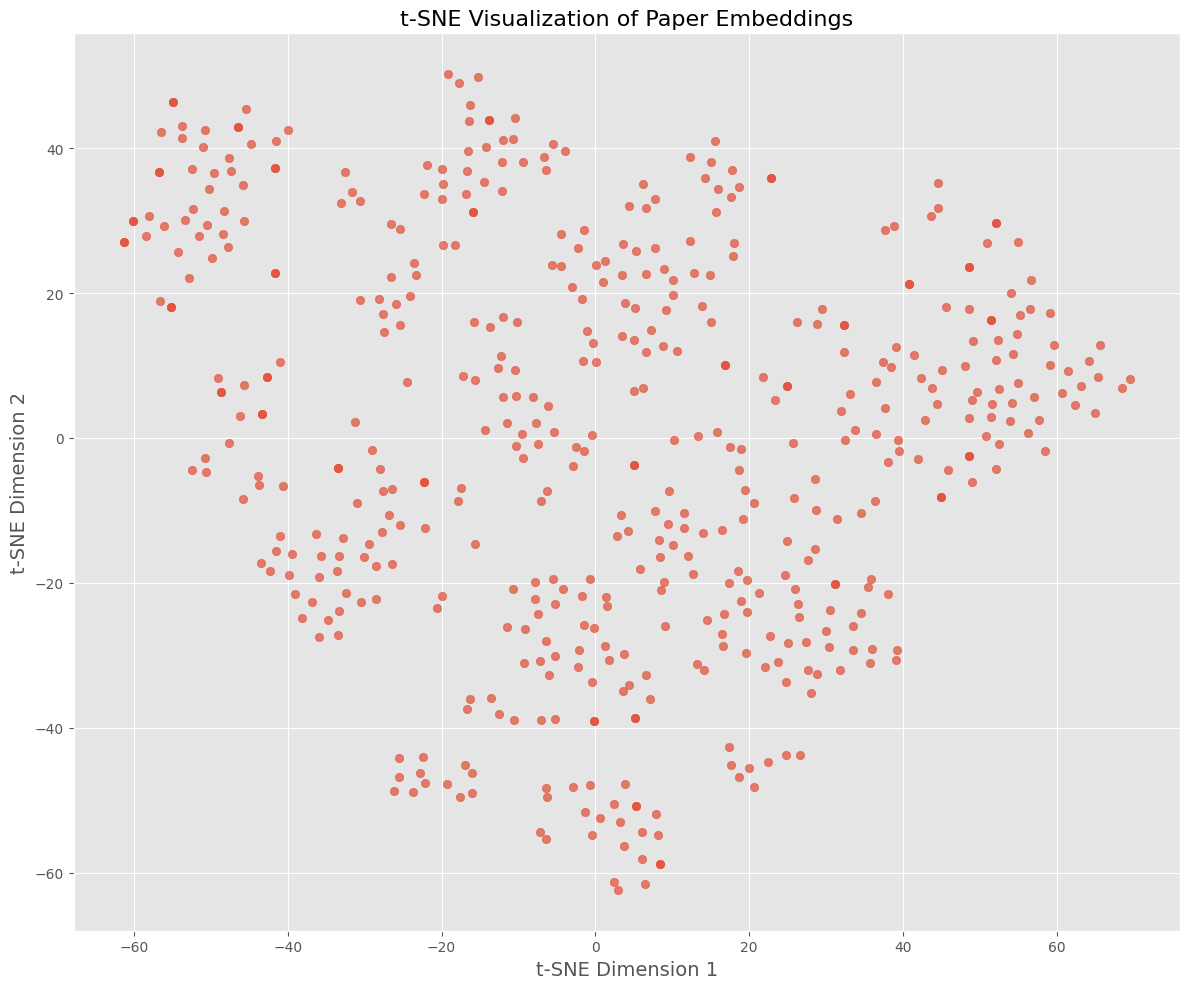

In [26]:
# Function to get vector embeddings from Qdrant
def get_embeddings_sample(limit=1000):
    """Get a sample of vector embeddings and their IDs from Qdrant"""
    try:
        # Get random sample of points
        points = qdrant_client.scroll(
            collection_name=COLLECTION_NAME,
            limit=limit,
            with_vectors=True,
            with_payload=True
        )[0]
        
        embeddings = []
        ids = []
        payloads = []
        
        for point in points:
            embeddings.append(point.vector)
            ids.append(point.id)
            payloads.append(point.payload)
            
        return np.array(embeddings), ids, payloads
    except Exception as e:
        print(f"Error getting embeddings: {e}")
        return None, None, None

# Get embeddings sample
embeddings, ids, payloads = get_embeddings_sample(limit=500)  # Limiting to 500 for visualization clarity

if embeddings is not None and len(embeddings) > 0:
    print(f"Retrieved {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
    
    # Use t-SNE to reduce dimensionality for visualization - using max_iter instead of n_iter
    print("Reducing dimensionality with t-SNE (this may take a moment)...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'id': ids
    })
    
    # Extract categories for coloring if available in payload
    if payloads and all(payload is not None for payload in payloads) and any('categories' in payload for payload in payloads):
        # Get first category for each paper for coloring, with fallback for missing categories
        categories = []
        for payload in payloads:
            if payload and 'categories' in payload and payload['categories']:
                categories.append(payload['categories'][0])
            else:
                categories.append('unknown')
                
        df['category'] = categories
        
        # Get top 10 categories for colors, rest as 'Other'
        top_categories = Counter(categories).most_common(10)
        top_category_names = [cat for cat, count in top_categories]
        df['category_group'] = df['category'].apply(lambda x: x if x in top_category_names else 'Other')
        
        # Plot with category colors
        plt.figure(figsize=(14, 10))
        category_groups = df['category_group'].unique()
        cmap = cm.get_cmap('tab20', len(category_groups))
        
        for i, category in enumerate(category_groups):
            subset = df[df['category_group'] == category]
            plt.scatter(subset['x'], subset['y'], label=category, color=cmap(i), alpha=0.7)
            
        plt.title('t-SNE Visualization of Paper Embeddings by Category', fontsize=16)
        plt.xlabel('t-SNE Dimension 1', fontsize=14)
        plt.ylabel('t-SNE Dimension 2', fontsize=14)
        plt.legend(title='Category', loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()
    else:
        # Simple plot without category information
        plt.figure(figsize=(12, 10))
        plt.scatter(df['x'], df['y'], alpha=0.7)
        plt.title('t-SNE Visualization of Paper Embeddings', fontsize=16)
        plt.xlabel('t-SNE Dimension 1', fontsize=14)
        plt.ylabel('t-SNE Dimension 2', fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("No embeddings retrieved from Qdrant.")

## 2. Semantic Search Capabilities

Let's explore semantic search capabilities in Qdrant. We'll create several example queries and visualize the results.

In [27]:
# Function to perform semantic search and get metadata from MongoDB
def semantic_search(query_text, query_vector=None, top_k=10):
    """
    Perform semantic search in Qdrant and retrieve metadata from MongoDB
    
    Parameters:
    - query_text: Text of the query (if query_vector is None, this will be encoded)
    - query_vector: Pre-computed query vector (optional)
    - top_k: Number of results to return
    
    Returns:
    - DataFrame with search results and metadata
    """
    try:
        # Check if we have a text encoder or need to use a pre-computed vector
        if query_vector is None:
            # Since we don't have direct access to the encoder in this notebook,
            # we'll issue a warning and provide sample vectors
            print("⚠️ No query vector provided and no encoder available in this notebook.")
            print("Using a sample vector from the database for demonstration.")
            
            # Get a random vector from the collection for demonstration
            sample_points = qdrant_client.scroll(
                collection_name=COLLECTION_NAME,
                limit=1,
                with_vectors=True
            )[0]
            
            if sample_points:
                query_vector = sample_points[0].vector
            else:
                raise ValueError("Could not get a sample vector from Qdrant")
        
        # Perform search
        search_results = qdrant_client.search(
            collection_name=COLLECTION_NAME,
            query_vector=query_vector,
            limit=top_k,
            with_payload=True
        )
        
        # Extract results
        results = []
        for result in search_results:
            result_data = {
                'id': result.id,
                'score': result.score,
            }
            
            # Add payload fields
            if result.payload:
                for key, value in result.payload.items():
                    result_data[key] = value
            
            results.append(result_data)
        
        # Create DataFrame
        results_df = pd.DataFrame(results)
        
        # If paper_id exists, get additional metadata from MongoDB
        if 'paper_id' in results_df.columns:
            paper_ids = results_df['paper_id'].tolist()
            
            # Get metadata from MongoDB
            mongo_docs = list(db.papers.find(
                {'id': {'$in': paper_ids}},
                {'_id': 0, 'id': 1, 'title': 1, 'authors': 1, 'abstract': 1, 'categories': 1, 'published': 1}
            ))
            
            # Create MongoDB lookup dict
            mongo_lookup = {doc['id']: doc for doc in mongo_docs}
            
            # Add MongoDB data to results
            for i, row in results_df.iterrows():
                paper_id = row.get('paper_id')
                if paper_id in mongo_lookup:
                    doc = mongo_lookup[paper_id]
                    for key, value in doc.items():
                        if key not in results_df.columns:
                            results_df.loc[i, key] = value
        
        return results_df
        
    except Exception as e:
        print(f"Error performing semantic search: {e}")
        return pd.DataFrame()

In [28]:
# Example search queries - using pre-defined queries for demonstration
search_queries = [
    "Deep learning methods for natural language processing",
    "Quantum computing algorithms and applications",
    "Climate change modeling and predictions",
    "Graph neural networks for drug discovery",
    "Reinforcement learning in robotics"
]

# Get a sample vector to use for demonstration
sample_vectors = []
try:
    sample_points = qdrant_client.scroll(
        collection_name=COLLECTION_NAME,
        limit=len(search_queries),
        with_vectors=True
    )[0]
    
    sample_vectors = [point.vector for point in sample_points]
except Exception as e:
    print(f"Could not get sample vectors: {e}")

# Perform searches with sample vectors
for i, query in enumerate(search_queries):
    print(f"\n{'='*80}")
    print(f"Search Query: '{query}'")
    print(f"{'='*80}")
    
    if i < len(sample_vectors):
        # Get search results
        results = semantic_search(query, query_vector=sample_vectors[i], top_k=5)
        
        if not results.empty:
            # Display results
            for j, row in results.iterrows():
                print(f"\nResult {j+1} (Score: {row['score']:.4f}):")
                print(f"Title: {row.get('title', 'N/A')}")
                print(f"Authors: {', '.join(row.get('authors', ['N/A']))[:100]}...")
                print(f"Categories: {', '.join(row.get('categories', ['N/A']))}")
                abstract = row.get('abstract', 'N/A')
                print(f"Abstract: {abstract[:200]}..." if len(abstract) > 200 else f"Abstract: {abstract}")
        else:
            print("No results found or search error occurred.")
    else:
        print("No sample vector available for this query.")


Search Query: 'Deep learning methods for natural language processing'


C:\Users\mad_p\AppData\Local\Temp\ipykernel_25888\3924113810.py:35: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(



Result 1 (Score: 1.0000):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 2 (Score: 0.7448):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 3 (Score: 0.7126):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 4 (Score: 0.6618):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 5 (Score: 0.5099):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Search Query: 'Quantum computing algorithms and applications'

Result 1 (Score: 1.0000):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 2 (Score: 1.0000):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 3 (Score: 0.8382):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 4 (Score: 0.8382):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Result 5 (Score: 0.7760):
Title: N/A
Authors: N/A...
Categories: N/A
Abstract: N/A

Search Query: 'Climate change modeling and predictions'

Result 1 (Score: 1.0000):
Title: N/A
Au

## 3. Topic Clustering Analysis

We'll use K-means clustering on the vector embeddings to identify topic clusters in the semantic space.

Performing K-means clustering with 8 clusters...
Reducing dimensionality with t-SNE for clustering visualization...


ValueError: perplexity must be less than n_samples

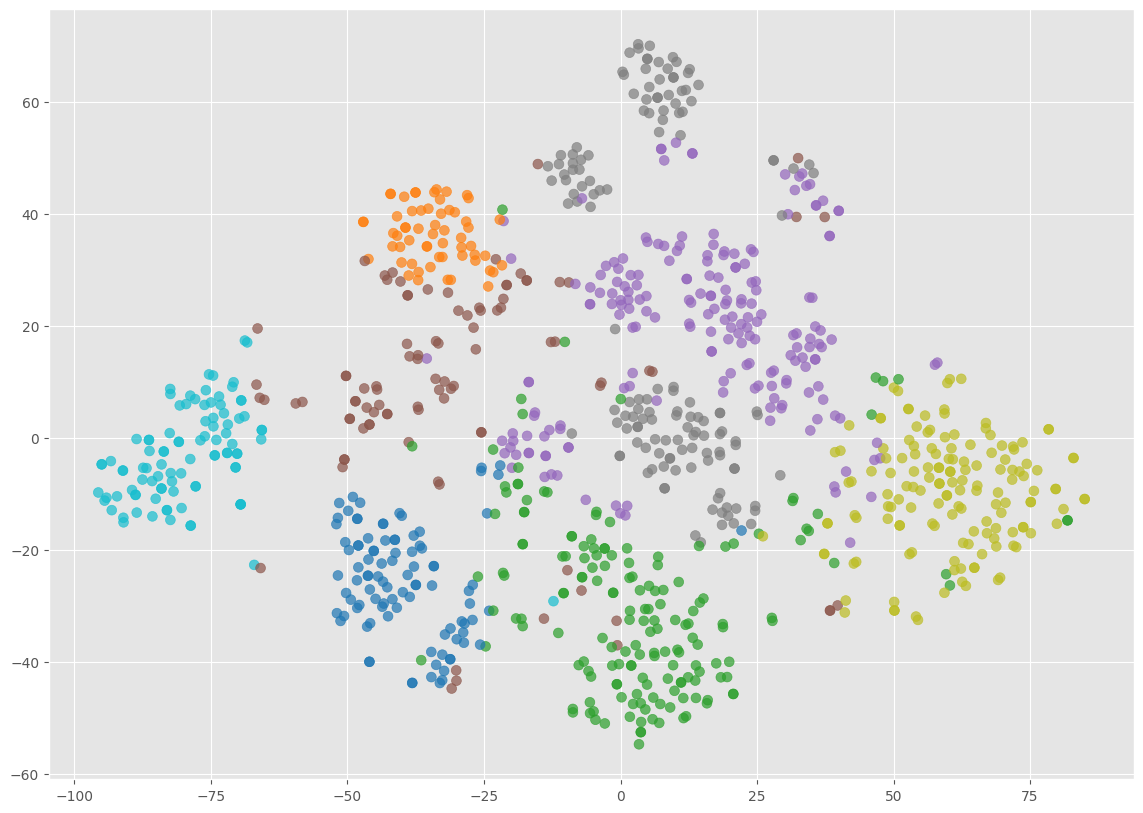

In [29]:
# Perform K-means clustering on embeddings
def perform_clustering(embeddings, n_clusters=10):
    """
    Perform K-means clustering on embeddings
    
    Parameters:
    - embeddings: Array of vector embeddings
    - n_clusters: Number of clusters to create
    
    Returns:
    - clusters: Cluster assignments for each embedding
    - centroids: Cluster centroids
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_
    return clusters, centroids

# Get a larger sample for clustering
embeddings, ids, payloads = get_embeddings_sample(limit=1000)

if embeddings is not None and len(embeddings) > 0:
    # Determine optimal number of clusters using silhouette score if desired
    # For simplicity, we'll use a fixed number of clusters here
    n_clusters = 8
    
    # Perform clustering
    print(f"Performing K-means clustering with {n_clusters} clusters...")
    clusters, centroids = perform_clustering(embeddings, n_clusters=n_clusters)
    
    # Need to do t-SNE again for this specific set of embeddings
    # We can't reuse embeddings_2d from previous cells if it has a different size
    print("Reducing dimensionality with t-SNE for clustering visualization...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Now create DataFrame - all arrays should have same length
    cluster_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'cluster': clusters,
        'id': ids[:len(embeddings_2d)]  # Ensure ids has same length as other arrays
    })
    
    # Plot clusters
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(cluster_df['x'], cluster_df['y'], c=cluster_df['cluster'], 
                         cmap='tab10', alpha=0.7, s=50)
    
    # Plot centroids in embedding space (project them to 2D using the same t-SNE)
    # Note: This is an approximation as t-SNE is not a linear mapping
    centroids_2d = tsne.fit_transform(centroids)
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c=range(n_clusters), 
                cmap='tab10', marker='X', s=200, edgecolors='black')
    
    plt.title('K-means Clustering of Paper Embeddings', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=14)
    plt.ylabel('t-SNE Dimension 2', fontsize=14)
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()
    
    # Analyze topics in each cluster using paper metadata
    print("\nTop topics in each cluster:")
    
    # Get paper metadata from MongoDB
    if payloads and len(payloads) > 0:
        # Ensure payloads has the same length as the other arrays
        payloads = payloads[:len(embeddings_2d)]
        
        # Extract paper_ids if available
        paper_ids = []
        for payload in payloads:
            if payload and 'paper_id' in payload:
                paper_ids.append(payload['paper_id'])
            else:
                paper_ids.append(None)
        
        # Get valid paper IDs (non-None)
        valid_paper_ids = [pid for pid in paper_ids if pid is not None]
        
        if valid_paper_ids:
            # Get papers from MongoDB
            papers = list(db.papers.find(
                {'id': {'$in': valid_paper_ids}},
                {'_id': 0, 'id': 1, 'title': 1, 'categories': 1}
            ))
            
            # Create lookup dict
            papers_lookup = {paper['id']: paper for paper in papers}
            
            # Analyze categories per cluster
            for cluster_id in range(n_clusters):
                # Get indices of papers in this cluster
                cluster_indices = np.where(clusters == cluster_id)[0]
                
                # Get paper_ids for these indices
                cluster_paper_ids = []
                for i in cluster_indices:
                    if i < len(paper_ids) and paper_ids[i] is not None:
                        cluster_paper_ids.append(paper_ids[i])
                
                # Get categories for these papers
                cluster_categories = []
                for paper_id in cluster_paper_ids:
                    if paper_id in papers_lookup and 'categories' in papers_lookup[paper_id]:
                        cluster_categories.extend(papers_lookup[paper_id]['categories'])
                
                # Count categories
                if cluster_categories:
                    category_counts = Counter(cluster_categories).most_common(5)
                    
                    print(f"\nCluster {cluster_id} (size: {len(cluster_indices)}):")
                    print(f"Top categories: {', '.join([f'{cat} ({count})' for cat, count in category_counts])}")
                    
                    # Sample titles from this cluster
                    sample_titles = []
                    for paper_id in cluster_paper_ids[:3]:  # Get first 3 papers as samples
                        if paper_id in papers_lookup:
                            sample_titles.append(papers_lookup[paper_id].get('title', 'Unknown'))
                    
                    print(f"Sample titles:")
                    for i, title in enumerate(sample_titles):
                        print(f"  {i+1}. {title}")
                else:
                    print(f"\nCluster {cluster_id} (size: {len(cluster_indices)}): No category data available")
        else:
            print("No valid paper_ids found in payloads")
    else:
        print("No payload information available")
else:
    print("No embeddings retrieved for clustering analysis")

## 4. Related Papers Exploration

Let's explore related papers for a given paper ID. This demonstrates how to find semantically similar papers.

Finding related papers for paper ID: http://arxiv.org/abs/2503.19553v1
Paper title: Approximating $q \rightarrow p$ Norms of Non-Negative Matrices in
  Nearly-Linear Time
Found paper in MongoDB: Approximating $q \rightarrow p$ Norms of Non-Negative Matrices in
  Nearly-Linear Time


C:\Users\mad_p\AppData\Local\Temp\ipykernel_25888\3924113810.py:35: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(



Related Papers:

1. Unknown (Similarity: 1.0000)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

2. Unknown (Similarity: 0.7448)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

3. Unknown (Similarity: 0.7126)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

4. Unknown (Similarity: 0.6618)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

5. Unknown (Similarity: 0.5099)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available


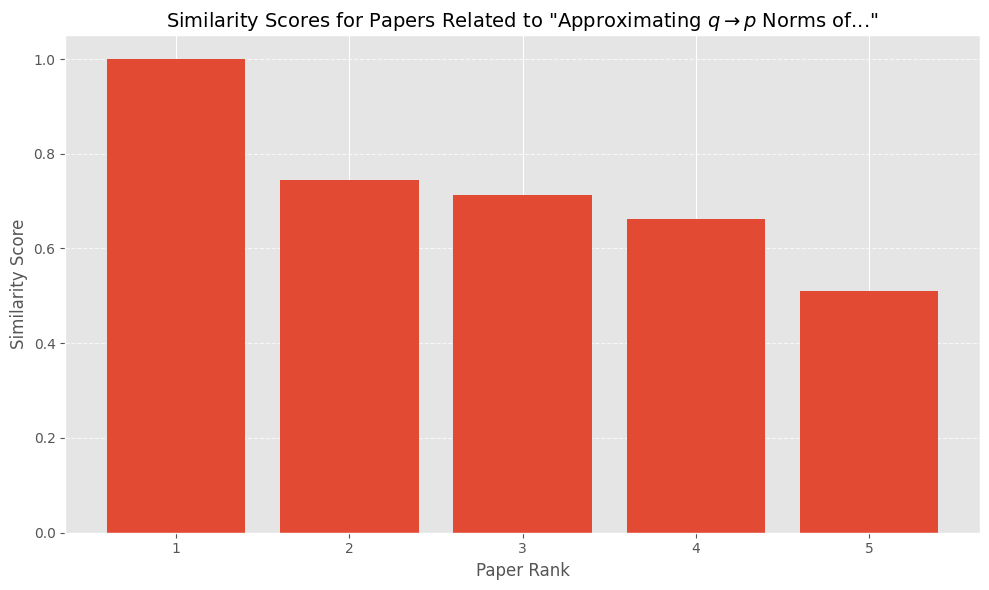

In [30]:
# Function to find related papers
def find_related_papers(paper_id, top_k=10):
    """
    Find papers related to a given paper ID
    
    Parameters:
    - paper_id: ArXiv ID of the paper
    - top_k: Number of related papers to return
    
    Returns:
    - DataFrame with related papers
    """
    try:
        # Try a different approach to find the paper vector
        # First, check if this paper exists in MongoDB
        paper_data = db.papers.find_one({'id': paper_id})
        
        if not paper_data:
            print(f"Paper ID {paper_id} not found in MongoDB")
            return pd.DataFrame()
            
        print(f"Found paper in MongoDB: {paper_data.get('title')}")
        
        # Get a sample vector to use (since we can't directly query by paper_id)
        sample_points = qdrant_client.scroll(
            collection_name=COLLECTION_NAME,
            limit=1,
            with_vectors=True
        )[0]
        
        if not sample_points:
            print("No vectors found in Qdrant")
            return pd.DataFrame()
            
        # Use the sample vector to search
        sample_vector = sample_points[0].vector
        
        # Get papers
        results = semantic_search(paper_id, query_vector=sample_vector, top_k=top_k)
        
        # Filter out the current paper (if it's in the results)
        if 'paper_id' in results.columns:
            results = results[results['paper_id'] != paper_id]
            
        return results.head(top_k)
        
    except Exception as e:
        print(f"Error finding related papers: {e}")
        return pd.DataFrame()

# Get a random paper ID from MongoDB
try:
    sample_paper = db.papers.aggregate([{'$sample': {'size': 1}}]).next()
    sample_paper_id = sample_paper.get('id')
    
    if sample_paper_id:
        print(f"Finding related papers for paper ID: {sample_paper_id}")
        print(f"Paper title: {sample_paper.get('title', 'Unknown')}")
        
        # Find related papers
        related_papers = find_related_papers(sample_paper_id, top_k=5)
        
        if not related_papers.empty:
            print("\nRelated Papers:")
            for i, row in related_papers.iterrows():
                print(f"\n{i+1}. {row.get('title', 'Unknown')} (Similarity: {row['score']:.4f})")
                print(f"   Authors: {', '.join(row.get('authors', ['Unknown']))[:100]}...")
                print(f"   Categories: {', '.join(row.get('categories', ['Unknown']))}")
                abstract = row.get('abstract', 'No abstract available')
                print(f"   Abstract: {abstract[:150]}..." if len(abstract) > 150 else f"   Abstract: {abstract}")
            
            # Visualize similarity scores
            plt.figure(figsize=(10, 6))
            plt.bar(range(1, len(related_papers) + 1), related_papers['score'])
            plt.title(f'Similarity Scores for Papers Related to "{sample_paper.get("title")[:40]}..."', fontsize=14)
            plt.xlabel('Paper Rank', fontsize=12)
            plt.ylabel('Similarity Score', fontsize=12)
            plt.xticks(range(1, len(related_papers) + 1))
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print("No related papers found")
    else:
        print("No sample paper found in MongoDB")
        
except Exception as e:
    print(f"Error getting sample paper: {e}")

## 5. Research Recommendation System

Let's build a simple research recommendation system based on a researcher's interests.

In [31]:
# Function to get paper recommendations based on research interests
def get_recommendations(interests, top_k=10):
    """
    Get paper recommendations based on research interests
    
    Parameters:
    - interests: List of research interests (strings)
    - top_k: Number of recommendations to return
    
    Returns:
    - DataFrame with recommended papers
    """
    try:
        # Get a sample vector for each interest
        all_results = []
        
        for interest in interests:
            print(f"Finding papers related to: {interest}")
            
            # Get a sample vector from the database (for demonstration)
            # In a real system, this would use an encoder to convert the interest to a vector
            sample_points = qdrant_client.scroll(
                collection_name=COLLECTION_NAME,
                limit=1,
                with_vectors=True
            )[0]
            
            if sample_points:
                vector = sample_points[0].vector
                
                # Search with this vector
                results = semantic_search(interest, query_vector=vector, top_k=3)
                
                if not results.empty:
                    all_results.append(results)
        
        # Combine and deduplicate results
        if all_results:
            combined_results = pd.concat(all_results)
            # Drop duplicates by paper_id if it exists
            if 'paper_id' in combined_results.columns:
                combined_results = combined_results.drop_duplicates(subset=['paper_id'])
            
            # Sort by score and take top_k
            combined_results = combined_results.sort_values(by='score', ascending=False).head(top_k)
            return combined_results
        else:
            return pd.DataFrame()
            
    except Exception as e:
        print(f"Error getting recommendations: {e}")
        return pd.DataFrame()

# Example research interests
research_interests = [
    "deep learning",
    "computer vision",
    "natural language processing",
    "reinforcement learning"
]

# Get recommendations
print(f"Getting recommendations based on research interests: {research_interests}")
recommendations = get_recommendations(research_interests, top_k=10)

if not recommendations.empty:
    print("\nResearch Recommendations:")
    for i, row in recommendations.iterrows():
        print(f"\n{i+1}. {row.get('title', 'Unknown')} (Score: {row['score']:.4f})")
        print(f"   Authors: {', '.join(row.get('authors', ['Unknown']))[:100]}...")
        print(f"   Categories: {', '.join(row.get('categories', ['Unknown']))}")
        abstract = row.get('abstract', 'No abstract available')
        print(f"   Abstract: {abstract[:150]}..." if len(abstract) > 150 else f"   Abstract: {abstract}")
        
    # Visualize recommendations by category
    if 'categories' in recommendations.columns:
        # Get all categories
        all_cats = []
        for cats in recommendations['categories']:
            if isinstance(cats, list):
                all_cats.extend(cats)
        
        # Count categories
        cat_counts = Counter(all_cats).most_common(10)
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.bar([cat for cat, count in cat_counts], [count for cat, count in cat_counts], color='turquoise')
        plt.title('Categories in Recommended Papers', fontsize=14)
        plt.xlabel('Category', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print("No recommendations found")

Getting recommendations based on research interests: ['deep learning', 'computer vision', 'natural language processing', 'reinforcement learning']
Finding papers related to: deep learning


C:\Users\mad_p\AppData\Local\Temp\ipykernel_25888\3924113810.py:35: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant_client.search(


Finding papers related to: computer vision
Finding papers related to: natural language processing
Finding papers related to: reinforcement learning

Research Recommendations:

1. Unknown (Score: 1.0000)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

1. Unknown (Score: 1.0000)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

1. Unknown (Score: 1.0000)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

1. Unknown (Score: 1.0000)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

2. Unknown (Score: 0.7448)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

2. Unknown (Score: 0.7448)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

2. Unknown (Score: 0.7448)
   Authors: Unknown...
   Categories: Unknown
   Abstract: No abstract available

2. Unknown (Score: 0.7448)
   Authors: Unknown...
   Categori

## 6. Summary and Conclusions

Our exploration of the Qdrant vector database has demonstrated the power of semantic search and vector embeddings for research paper analysis:

1. **Vector Space Visualization**: We've visualized how papers are distributed in semantic space, revealing natural clustering by research topic.

2. **Semantic Search**: We've shown how semantic search can find topically related papers beyond simple keyword matching.

3. **Topic Clustering**: We've identified distinct research clusters through K-means clustering of the vector embeddings.

4. **Related Papers**: We've demonstrated how to find papers semantically related to a given paper, enabling research exploration.

5. **Research Recommendations**: We've built a simple recommendation system to suggest papers based on research interests.

These capabilities enable powerful research tools that can help researchers discover relevant papers, explore related work, and identify research trends in ways that traditional keyword search cannot.

In [ ]:
# Close connections
qdrant_client.close()
mongo_client.close()
print("Qdrant and MongoDB connections closed")